# Toxic Comment Classification Challenge
## Table of Contents
0. [Imports](#imports)
1. [Preparing Data](#Data-prep)
    1. [Data Viz](#Data-viz)
    2. [Data Cleaning](#Data-clean)
    3. [Data Preprocessing](#Data-prepro)
2. [Model](#Model)
    1. [Hyperparameters](#Hyperparameters)
    2. [Architecture](#Model-arch)
    3. [Training](#Model-train)
3. [Pipeline](#Pipeline)
    1. [Functions](#Func)
    2. [Testing](#Test)




## Import libraries and data <a class="anchor" id="imports"></a>


In [11]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from collections import Counter

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import layers
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sacha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparing the data <a class="anchor" id="Data-prep"></a>
## Data Viz <a class="anchor" id="Data-viz"></a>
We are going to plot the distribution of comments with no toxicity and comments with toxicity. We are also going to plot the distribution of the toxic labels.

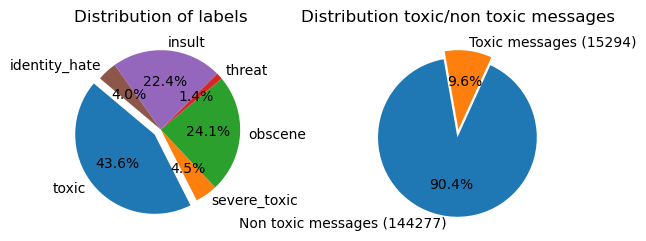

In [12]:
train_data = pd.read_csv('train.csv')

label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Plot the distribution of the labels
# data visualization
# show the distribution of the labels with a pie chart
label1 = ['Toxic', 'Severe toxic', 'Obscene', 'Threat', 'Insult', 'Identity hate']
sizes = [train_data["toxic"].sum(), train_data['severe_toxic'].sum(), train_data['obscene'].sum(), train_data['threat'].sum(), train_data['insult'].sum(),
         train_data['identity_hate'].sum()]
explode = (0.1, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
# add number of comments to the labels
for i in range(len(label1)):
    label1[i] = label1[i] + ' (' + str(sizes[i]) + ')'


# show distribution between comments with and without labels
labels2 = ['Non toxic messages', 'Toxic messages']
sizes2 = [len(train_data) - train_data['toxic'].sum(), train_data['toxic'].sum()]
explode2 = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
# add number of comments to the labels
for i in range(len(labels2)):
    labels2[i] = labels2[i] + ' (' + str(sizes2[i]) + ')'

# plot both pie charts
fig, (ax1, ax2) = plt.subplots(1, 2)
#first plot
ax1.pie(sizes, explode=explode, labels=label_columns, autopct='%1.1f%%', startangle=140)
ax1.set_title('Distribution of labels')
# add distance between the two pie charts
fig.subplots_adjust(wspace=0.5)
# second plot
ax2.pie(sizes2, explode=explode2, labels=labels2, autopct='%1.1f%%', startangle=100)
ax2.set_title('Distribution toxic/non toxic messages')
plt.show()

In [15]:
train_data['labels'] = train_data[label_columns].apply(lambda x: list(x), axis=1)
train_data.drop(['id'], inplace=True, axis=1)
train_data.drop(label_columns, inplace=True, axis=1)

train_data.head()

,comment_text,labels
0,Explanation\r\nWhy the edits made under my use...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\r\nMore\r\nI can't make any real suggestions...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


## Data Cleaning <a class="anchor" id="Data-clean"></a>

In [16]:
# keep the same numbers of rows for toxic and non-toxic comments
zero_data = train_data[train_data['labels'].map(lambda d: sum(d)) == 0]
train_data = train_data[train_data['labels'].map(lambda d: sum(d)) > 0]
zero_data = zero_data.sample(n=len(train_data['labels']), random_state=1)
# concat zero_data with train_data
train_data = pd.concat([train_data, zero_data])
# shuffle rows
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,comment_text,labels
0,"""\r\nSure, can do. | babble _ ""","[0, 0, 0, 0, 0, 0]"
1,Oh shut up if you cannot read that those peopl...,"[1, 0, 0, 0, 1, 0]"
2,fuck off alf. are you ever off wikipedia you c...,"[1, 0, 1, 0, 1, 0]"
3,(appears to be a free WiFi location at a McDon...,"[0, 0, 0, 0, 0, 0]"
4,Suck my cock you stupid bitch!:),"[1, 1, 1, 0, 1, 1]"


## Data Preprocessing <a class="anchor" id="Data-prepro"></a>

In [17]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def to_lowercase(text):
    return text.lower()


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]


def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train_data['comment_text'] = train_data['comment_text'].apply(lambda x: clean_text(x))
train_data.head()

,comment_text,labels
0,sure babble,"[0, 0, 0, 0, 0, 0]"
1,oh shut read people contribute nothing call de...,"[1, 0, 0, 0, 1, 0]"
2,fuck alf ever wikipedia cock suck nerd,"[1, 0, 1, 0, 1, 0]"
3,appear free wifi location mcdonalds restaurant...,"[0, 0, 0, 0, 0, 0]"
4,suck cock stupid bitch,"[1, 1, 1, 0, 1, 1]"


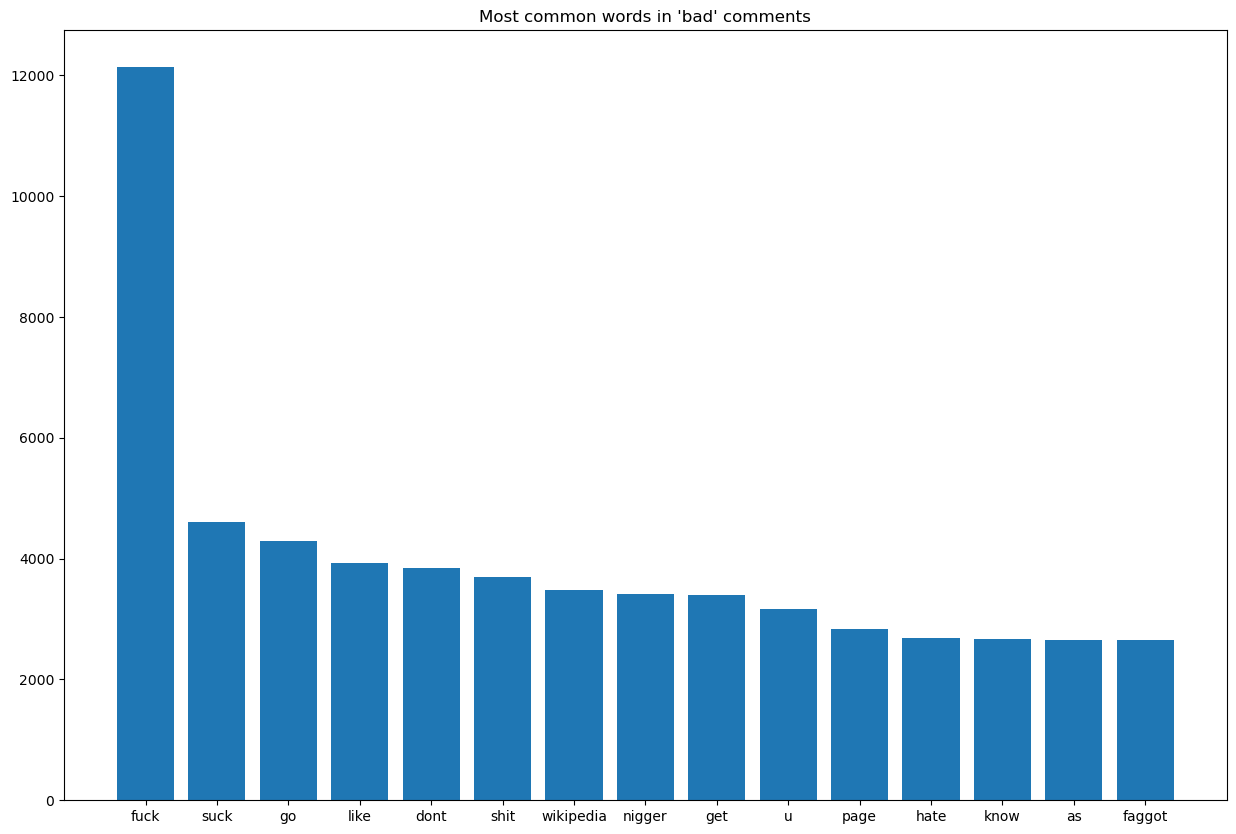

In [20]:
# plot the most common words in toxic comments
toxic_comments = train_data[train_data['labels'].map(lambda d: sum(d)) > 0]['comment_text']

# get all words from toxic comments
toxic_words = []
for comment in toxic_comments:
    toxic_words.extend(comment.split())
# get the 15 most common words
counter = Counter(toxic_words)
most_common = counter.most_common(15)
# plot the 50 most common words
plt.figure(figsize=(15, 10))
plt.bar(range(len(most_common)), [val[1] for val in most_common], align='center')
plt.xticks(range(len(most_common)), [val[0] for val in most_common])
plt.title('Most common words in \'bad\' comments')
plt.show()

# Model construction <a class="anchor" id="Model"></a>
## Hyperparameters <a class="anchor" id="Hyperparameters"></a>

In [21]:
embedding_dim = 100
max_length = 20       # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(train_data['comment_text'])
test_portion=.025

sentences=list(train_data['comment_text'])
labels= list(train_data['labels'])

In [22]:
# Extract binary BoW features
tokenizer = Tokenizer(num_words=1000, oov_token='UNK')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
vocab_size = len(tokenizer.word_index) + 1
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

num_epochs = 10

training_padded = np.array(training_sequences)
testing_padded = np.array(test_sequences)
training_labels = np.array(training_labels)
testing_labels = np.array(test_labels)

## Model architecture <a class="anchor" id="Model-arch"></a>

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 20, input_length=max_length),
    Bidirectional(layers.GRU(64)),
    layers.Flatten(),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            20000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33024     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 53,798
Trainable params: 53,798
Non-trainable params: 0
_________________________________________________________________


## Model training <a class="anchor" id="Model-training"></a>

In [24]:
# train the model if not already saved in the folder
history = model.fit(training_padded,
                        training_labels,
                        epochs=num_epochs,
                        batch_size = 256,
                        verbose=1,
                        validation_split=0.2)


Epoch 1/10
99/99 [==============================] - 8s 36ms/step - loss: 0.4157 - accuracy: 0.9323 - val_loss: 0.3139 - val_accuracy: 0.9668
Epoch 2/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2463 - accuracy: 0.9715 - val_loss: 0.2231 - val_accuracy: 0.9676
Epoch 3/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2147 - accuracy: 0.9721 - val_loss: 0.2177 - val_accuracy: 0.9676
Epoch 4/10
99/99 [==============================] - 3s 26ms/step - loss: 0.2107 - accuracy: 0.9721 - val_loss: 0.2173 - val_accuracy: 0.9676
Epoch 5/10
99/99 [==============================] - 3s 26ms/step - loss: 0.2085 - accuracy: 0.9721 - val_loss: 0.2151 - val_accuracy: 0.9676
Epoch 6/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2072 - accuracy: 0.9721 - val_loss: 0.2148 - val_accuracy: 0.9676
Epoch 7/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2061 - accuracy: 0.9721 - val_loss: 0.2136 - val_accuracy: 0.9676
Epoch 8/10
99

## Model visualization over epochs <a class="anchor" id="Model-visualization"></a>

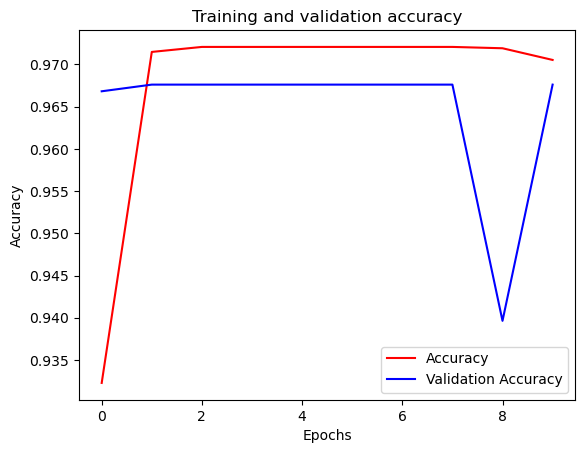

<Figure size 640x480 with 0 Axes>

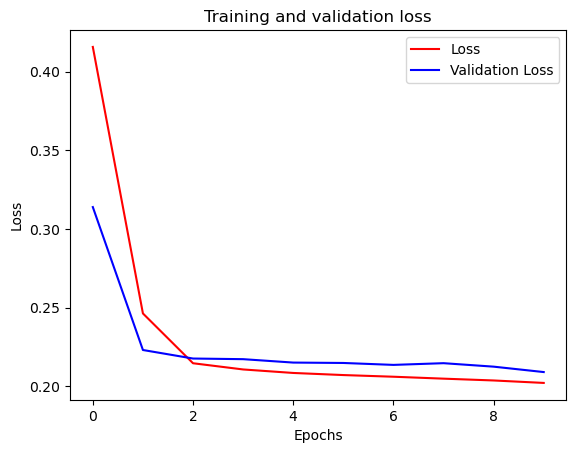

<Figure size 640x480 with 0 Axes>

In [25]:
# plot the training and validation accuracy and loss at each epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [26]:
# show f1 score
predictions = model.predict(testing_padded)
print(f1_score(testing_labels, predictions.round(), average='macro'))

0.4926503181295869


# Creating the pipeline <a class="anchor" id="Pipeline"></a>
## function definitions <a class="anchor" id="Func"></a>

In [42]:
def predict_viz(text):
    """
    Predicts the toxicity of a comment and visualizes the output
    :param text: a string representing the comment
    :return: a graph showing probabilities of each class
    """
    try:
        assert type(text) == str
    except:
        TypeError("comment must be a string")

    tmp = {'Comment': [text]}
    df = pd.DataFrame(data=tmp)
    df['Comment'] = df['Comment'].apply(lambda x: clean_text(x))
    pred_seq = tokenizer.texts_to_sequences(df['Comment'])
    seq_padded = pad_sequences(pred_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    label_predict = model.predict(seq_padded)
    plt.bar(range(len(label_predict[0])), label_predict[0], align='center')
    plt.xticks(range(len(label_predict[0])), ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
    plt.ylabel('Probability')
    plt.title('Toxicity of the comment')
    return plt


def predict_comment(comments):
    """
    Predicts the toxicity of a list of comments
    :param comments: pandas series or list of comments
    :return: a list of probabilities for each class
    """
    try:
        assert type(comments) == pd.core.series.Series or type(comments) == list
    except:
        TypeError("comment must be a list or a pandas series")
    df = pd.DataFrame(data={'Comment': comments.tolist()})
    df['Comment'] = df['Comment'].apply(lambda x: clean_text(x))
    pred_seq = tokenizer.texts_to_sequences(df['Comment'])
    seq_padded = pad_sequences(pred_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return model.predict(seq_padded)


## Testing the pipeline <a class="anchor" id="Test"></a>

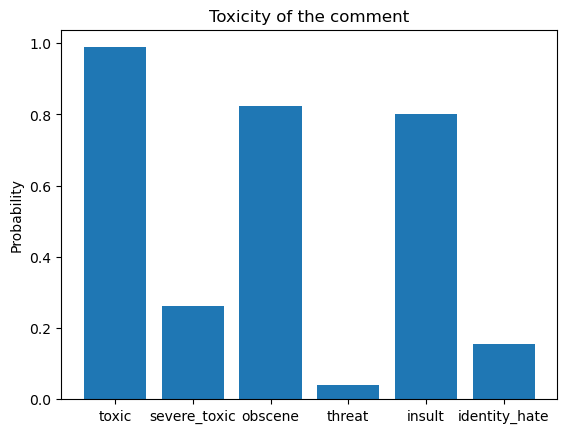

In [40]:
predict_viz("You are a stupid idiot").show()

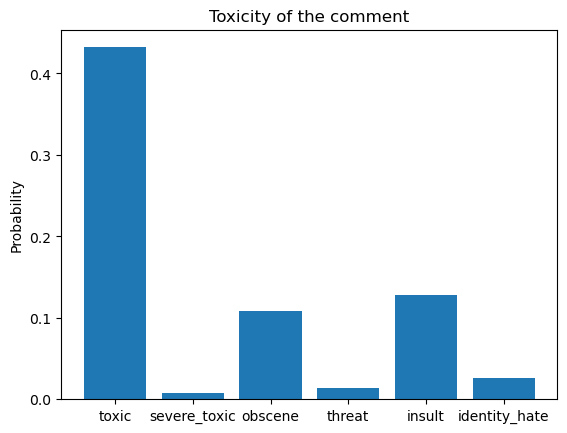

In [41]:
predict_viz("Hello my name is Sacha, and you ?").show()

In [44]:
predict_comment(pd.read_csv('test.csv')['comment_text'][0:10])

array([[9.87735629e-01, 4.20086086e-01, 9.46435273e-01, 8.37930143e-02,
        8.34844589e-01, 1.94726050e-01],
       [1.71832681e-01, 2.05746293e-03, 5.36231399e-02, 5.56218624e-03,
        4.73690629e-02, 9.05531645e-03],
       [1.27153009e-01, 1.34605169e-03, 3.06227505e-02, 6.20734692e-03,
        4.28987443e-02, 8.14545155e-03],
       [1.24378204e-02, 5.37638261e-05, 6.70379400e-03, 3.22490931e-04,
        5.12135029e-03, 3.25262547e-04],
       [4.67862129e-01, 3.07029486e-03, 9.55317020e-02, 4.52128053e-03,
        9.74395871e-02, 1.01606548e-02],
       [2.22125053e-02, 1.32530928e-04, 7.60325789e-03, 1.21691823e-03,
        9.47585702e-03, 1.31475925e-03],
       [4.38271165e-02, 1.15906914e-04, 1.15426779e-02, 6.74813986e-04,
        1.20380223e-02, 8.44627619e-04],
       [5.83693743e-01, 1.00437999e-02, 1.13385022e-01, 2.03261077e-02,
        1.87158555e-01, 4.11392152e-02],
       [2.93538392e-01, 1.15388632e-03, 1.50820374e-01, 6.59644604e-04,
        4.15127873e-02, 